## LandCoverNet Model Training

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.

This portion of the tutorial is focused on developing a semantic segmentation model for LandCoverNet data

Here:

1. We will load the prepared data as into the non-overlapping training, test and validation data sets

4. We will build a semantic segmentation model, train it on the training data, inspect the results on the validation data and make predictions on the test data

#### Importing the needed libraries

In [1]:
import numpy as np
import pandas as pd

import contextlib
import warnings

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

2022-02-24 10:50:31.806546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Loading the data

We will then load the prepared data defined by the least cloudy RGB source images across all labels taken quarterly throughout the year (every three months).

In [2]:
tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
with open (f'{tmp_dir}/landcovnet/items.pkl', 'rb') as fp:
    Xys = pickle.load(fp)

In [3]:
temp=[]
for i in range (0, len(Xys)):
    temp.append(Xys[i][0].data)
temp = [it for sub in temp for it in sub]
temp = np.asarray(temp)
temp = temp.swapaxes(1,2) #transform axis to desired shape
temp = temp.swapaxes(2,3)
X=temp

In [4]:
X.shape #desired shape (1980x4) items

(7892, 256, 256, 3)

In [4]:
total=0
total_list=[]
for i in range(0,len(Xys)):
    total+=len(Xys[i][0])
    total_list.append(total) #this saves the index of the label's first image, then the next label's first image, etc.

In [9]:
for i in range(0,len(total_list)-1):
    if total_list[i+1]!=total_list[i]+4: #the label does not contain four source images
        print(total_list[i+1], total_list[i+1]-total_list[i]) #print number of images that label has at the first image's index

211 3
354 3
1675 1
2146 3
2841 3
3352 3
3375 3
3418 3
3437 3
4540 3
4738 2
4857 3
4876 3
5102 2
5105 3
5210 1
6003 1
6422 3
6577 3
7292 3


In [60]:
flat_list = np.concatenate(X[0:3], axis=2)#roll the data

In [59]:
flat_list.shape

(256, 256, 9)

In [23]:
total=0
total_list=[]
for i in range(0,len(Xys)):
    total+=len(Xys[i][0])
    total_list.append(total)
Y= np.zeros((total, 256, 256), dtype=np.float32)
i=0
for j in range(0, len(total_list)): #duplicate the labels for the source images belonging to a label item
    Y[i:total_list[j]]=Xys[j][1][0].data
    i=total_list[j]

# #clear up memory
# del Xys
# del temp
# del total_list

In [5]:
X=X[0:200] #selecting subset
Y=Y[0:200]

In [6]:
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
del X #clear memory
del Y

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(140, 256, 256, 3)
(140, 256, 256)
(30, 256, 256, 3)
(30, 256, 256)
(30, 256, 256, 3)
(30, 256, 256)


### Building the model

We will make use of semantic segmentation using U-Net.

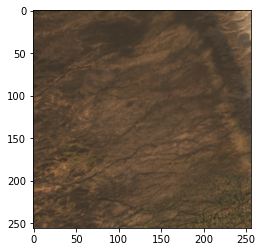

In [20]:
#view a random image
plt.imshow(x_train[107])

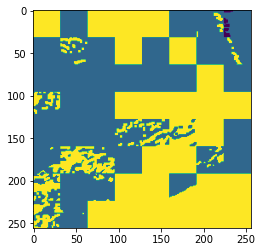

In [18]:
plt.imshow(y_train[107]) #display corresponding label

#### Building the U-Net architecture
This model was thanks to YOUCEF GUICHI on Kaggle's  Aerial Semantic Segmentation Drone Dataset.

Their implementation can be found [here](https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc).

For this tutorial, some tweaks were made on the referenced implementation to suit our application

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [10]:
def unet_model(input_size=(256, 256, 12), n_filters=8, n_classes=64):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.6) 
    
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.6, max_pooling=None)  
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [15]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [16]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 8)  224         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 256, 256, 8)  584         conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_61[0][0]                  
____________________________________________________________________________________________

In [11]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Helper Functions During Model Training

ZAKIR ZEYNALOV on Kaggle for the same Aerial Semantic Segmentation Drone Dataset, made some useful helper functions below which can be used in conjuction with training.
Their implementation can be found [here](https://www.kaggle.com/menhior/aerial-drone-shots-image-segmentation)

They can be included in `unet.fit` for the callback parameter as shown in the comments for the code at the model training stage.

Since we were running across 100 epochs, they weren't included to make the output simple, although this applies particularly to `DisplayCallback()`. `ModelCheckpoint` and `EarlyStopping` can still be included for saving the model at the epoch with the best result and interrupting training when there's no improvement in results respectively (in our case, we chose 50 epochs).

In [12]:
model_checkpoint = ModelCheckpoint(tmp_dir+'/landcovnet/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [1]:
history = unet.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=30)

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [443]:
import random #random displayed item
train_id = random.randint(0, len(x_train)-1)
train_id

137

In [16]:
test_results = unet.evaluate(x_test, y_test, batch_size = 16) #evaluate the test results

2/2 [==============================] - 0s 57ms/step - loss: 1.0066 - accuracy: 0.6711


In [481]:
print(1)

1


1/1 [==============================] - 0s 18ms/step - loss: 0.9450 - accuracy: 0.7017


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.944966733455658, 0.70172119140625]
1


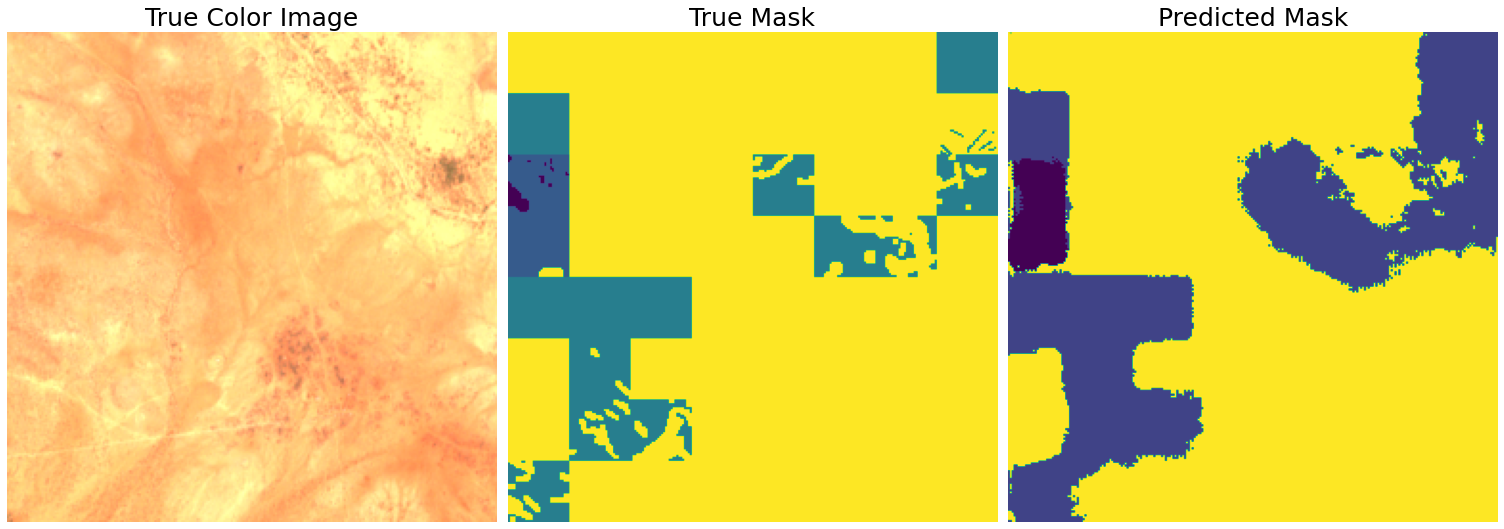

In [19]:
import random
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,10.80))
i=random.randint(0, len(x_test)-1)
test_result= unet.evaluate(np.expand_dims(x_train[i], 0),np.expand_dims(y_train[i], 0))
pred_mask = unet.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result) #print results on the random field
print (i) #print ID
# Perform a sanity check on some random training samples
plt.subplot(1, 3, 1)
fontsize =25
axes[0].imshow(x_test[i]*2)
plt.title("True Color Image", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1, 3, 2)
axes[1].imshow(y_test[i])
plt.title("True Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1,3,3)
axes[2].imshow(pred_mask) #prediction without threshold
plt.title("Predicted Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
fig.tight_layout()

1/1 [==============================] - 0s 18ms/step - loss: 0.0155 - accuracy: 0.9998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.015507618896663189, 0.9998321533203125]
14


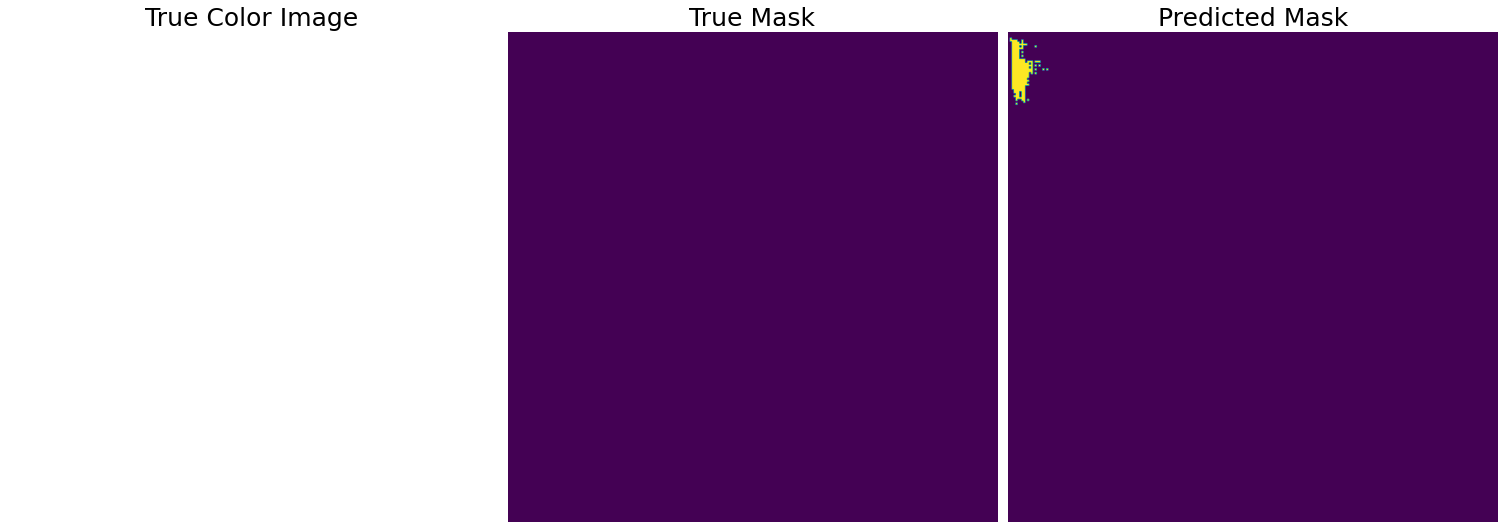

In [25]:
import random
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,10.80))
i=random.randint(0, len(x_test)-1)
test_result= unet.evaluate(np.expand_dims(x_train[i], 0),np.expand_dims(y_train[i], 0))
pred_mask = unet.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result) #print results on the random field
print (i) #print ID
# Perform a sanity check on some random training samples
plt.subplot(1, 3, 1)
fontsize =25
axes[0].imshow(x_test[i]*2)
plt.title("True Color Image", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1, 3, 2)
axes[1].imshow(y_test[i])
plt.title("True Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1,3,3)
axes[2].imshow(pred_mask) #prediction without threshold
plt.title("Predicted Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
fig.tight_layout()